In [29]:
import wrapper as wp
import pandas as pd
import os
from itertools import product
import plotly.express as px

df = pd.read_csv("Feature_Matrix_delta_AR24.csv")

In [30]:
priolist = ['model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_ID_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_net_only_typelinear.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_net_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_net_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilenarratives_ID_only_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profileBM_composite_typelassocv.pkl',
'model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl',
'model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl']

## Run models

-> Now saving model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl
✅ No columns dropped by variance thresholding.
Number of Non-zero coefficients: 5
Test MSE: 0.000004
Non-zero coefficients:
delta_log_cpi_next_month_lag1    0.002560
delta_log_cpi_next_month_lag2   -0.000914
delta_log_cpi_next_month_lag5   -0.000374
delta_log_cpi_next_month_lag4    0.000240
delta_log_cpi_next_month_lag3   -0.000024
dtype: float64

Last train date: 2023-03-01 00:00:00 self.testsize: 0.012
BM_poormans linear model fitted from 2001-05-01 to 2025-02-01 with lag = 5 months and lead = 1 months.
Model saved to run_1807/model_lag6_scalerStandard_lead1_profileBM_poormans_typelinear.pkl.
-> Now saving model_lag6_scalerStandard_lead1_profilecontrols_typelassocv.pkl
✅ No columns dropped by variance thresholding.
Number of Non-zero coefficients: 2
Optimal alpha: 0.0005933717538503723
Test MSE: 0.000001
Non-zero coefficients:
delta_log_cpi_next_month_lag1    0.001484
GSCI_Cotton_lag0                 0.00

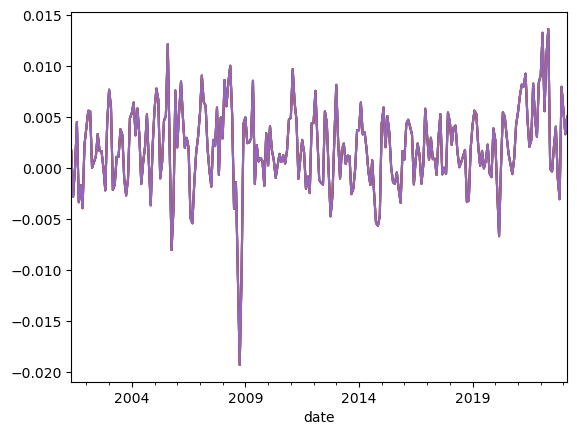

In [31]:
# Define the parameter grid
max_lags = [1, 3, 6, 12]
scalers = ["Standard", "zca"]
leads = [1]#[1, 3, 6]
profiles = ["BM_poormans",
    "narratives_and_composite", "controls", "narratives", "narratives_net_only",
    "narratives_ID_only", "BM_composite", "BM_composite_net_only", "all_features"
]
modeltypes = ["linear", "lassocv", "elasticnetcv"]

# Create output directory
output_dir = 'run_1807'
os.makedirs(output_dir, exist_ok=True)

# Loop through all combinations
for lag, scaler, lead, profile, modeltype in product(max_lags, scalers, leads, profiles, modeltypes):
    model = wp.Model(df)
    #model.auto_print = False
    model.testsize = 0.012
    model.window = 286
    model.set_maxlag(lag)
    model.scaler = scaler
    model.lead = lead
    model.set_profile(profile)
    model.set_modeltype(modeltype)

    # Generate filename based on parameters
    filename = f"model_lag{lag}_scaler{scaler}_lead{lead}_profile{profile}_type{modeltype}.pkl"
    filepath = os.path.join(output_dir, filename)

    # Run and save the model
    if not (scaler=='zca' and profile=='BM_poormans') and filename in priolist:
        print(f"-> Now saving {filename}")
        model.run_model(save_to_dir=[output_dir, filename])


## Evaluate Models

In [ ]:
import glob
import joblib
from single_model_test import EvaluationSingleModel
# Find all .pkl files in the models/ subfolder
subfolder = "run_1807"
pkl_files = glob.glob(subfolder+"/*.pkl")

rmse_dfs = []
model_names = []

for pkl_file in pkl_files:
    model_name = pkl_file.split("/")[-1].replace(".pkl", "")
    print(f"Processing : {pkl_file}")
    print(joblib.load(pkl_file))
    model = EvaluationSingleModel(model_dict=joblib.load(pkl_file), df=df, mute = True)
    rmse_df = model.rolling_forward_rmse(window_size=12)
    rmse_df = rmse_df.rename(columns={"rmse": model_name})
    # Ensure start_date is in datetime format with dayfirst=True
    rmse_df["start_date"] = pd.to_datetime(rmse_df["start_date"], dayfirst=True)
    rmse_dfs.append(rmse_df.set_index("start_date"))
    model_names.append(model_name)

# Join all rmse_dfs on start_date
rmse_all = pd.concat(rmse_dfs, axis=1).reset_index()
print(rmse_all['start_date'].iloc[0])
#rmse_all.to_csv("run_1507/all_models_rmse.csv")
print(f'Number of models computed: {len(rmse_all.columns)}')
fig = px.line(rmse_all, x="start_date", y=rmse_all.columns, title="12-Month Forward RMSE Over Time for Non-Linear Models")
fig.update_yaxes(range=[0, 0.01])
#fig.update_layout(showlegend=False)
fig.show()

Processing : run_1807\model_lag12_scalerStandard_lead1_profileall_features_typelassocv.pkl
{'model': LassoCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
        max_iter=100000, random_state=42), 'alpha': 0.0003903989914314919, 'mse': 3.47609866472217e-06, 'feature_names': Index(['std_SD_aluminium_AU_lag0', 'std_SI_aluminium_AU_lag0',
       'std_DD_aluminium_AU_lag0', 'std_DI_aluminium_AU_lag0',
       'std_netD_aluminium_AU_lag0', 'std_netS_aluminium_AU_lag0',
       'std_SD_cattle_AU_lag0', 'std_SI_cattle_AU_lag0',
       'std_DD_cattle_AU_lag0', 'std_DI_cattle_AU_lag0',
       ...
       'GSCI_Sugar_lag11', 'GSCI_Coffee_lag11', 'GSCI_Cocoa_lag11',
       'GSCI_LiveCattle_lag11', 'GSCI_FeederCattle_lag11',
       'GSCI_LeanHogs_lag11', 'GSCI_Composite_lag11', 'Tbill10Y_lag11',
       'Tbill1mo_lag11', 'delta_log_cpi_next_month_lag11'],
      dtype='object', length=2111), 'non_zero_coefs': std_SI_corn_AU_lag0              -7.805884e-05
std_DD_gasoil_A

In [28]:
# Drop 'linear' columns
rmse_non_linear = rmse_all[[col for col in rmse_all.columns if 'linear' not in col]]

# Average columns containing 'zca' and 'Standard'
zca_cols = [col for col in rmse_non_linear.columns if 'zca' in col]
standard_cols = [col for col in rmse_non_linear.columns if 'Standard' in col]

rmse_avg = pd.DataFrame({
    'start_date': rmse_all['start_date'],
    'ZCA scaling': rmse_non_linear[zca_cols].mean(axis=1),
    'Standard scaling': rmse_non_linear[standard_cols].mean(axis=1)
})

fig = px.line(rmse_avg, x="start_date", y=['ZCA scaling', 'Standard scaling'], title="Average RMSE: ZCA vs Standard scaling Over Time for regularized models")
fig.update_yaxes(range=[0, 0.01])
fig.show()

In [16]:
rmse_all = pd.read_csv("run_1507/all_models_rmse.csv")
rmse_all['start_date'] = pd.to_datetime(rmse_all['start_date'], format='%Y-%d-%m %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')
df_rmse = rmse_all.drop(columns=[col for col in rmse_all.columns if 'lead3' in col or 'lead6' in col])
df_rmse

,Unnamed: 0,start_date,run_1507\model_lag12_scalerStandard_lead1_profileall_features_typeelasticnetcv,run_1507\model_lag12_scalerStandard_lead1_profileall_features_typelassocv,run_1507\model_lag12_scalerStandard_lead1_profileall_features_typelinear,run_1507\model_lag12_scalerStandard_lead1_profileBM_composite_net_only_typeelasticnetcv,run_1507\model_lag12_scalerStandard_lead1_profileBM_composite_net_only_typelassocv,run_1507\model_lag12_scalerStandard_lead1_profileBM_composite_net_only_typelinear,run_1507\model_lag12_scalerStandard_lead1_profileBM_composite_typeelasticnetcv,run_1507\model_lag12_scalerStandard_lead1_profileBM_composite_typelassocv,...,run_1507\model_lag6_scalerzca_lead1_profilenarratives_and_composite_typelinear,run_1507\model_lag6_scalerzca_lead1_profilenarratives_ID_only_typeelasticnetcv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_ID_only_typelassocv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_ID_only_typelinear,run_1507\model_lag6_scalerzca_lead1_profilenarratives_net_only_typeelasticnetcv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_net_only_typelassocv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_net_only_typelinear,run_1507\model_lag6_scalerzca_lead1_profilenarratives_typeelasticnetcv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_typelassocv,run_1507\model_lag6_scalerzca_lead1_profilenarratives_typelinear
0,0,2001-05-01 00:00:00,0.002386,0.002386,0.000205,0.003057,0.003057,0.002691,0.003178,0.003178,...,0.000059,0.003465,0.003465,0.000090,0.003465,0.003465,0.001061,0.003465,0.003465,0.000059
1,1,2001-06-01 00:00:00,0.002340,0.002339,0.000209,0.003037,0.003036,0.002733,0.003162,0.003161,...,0.000060,0.003434,0.003434,0.000091,0.003434,0.003434,0.000959,0.003434,0.003434,0.000060
2,2,2001-07-01 00:00:00,0.002388,0.002388,0.000209,0.003014,0.003014,0.002907,0.003140,0.003138,...,0.000059,0.003352,0.003352,0.000091,0.003352,0.003352,0.000925,0.003352,0.003352,0.000058
3,3,2001-08-01 00:00:00,0.002523,0.002523,0.000200,0.003031,0.003031,0.002905,0.003175,0.003175,...,0.000054,0.003487,0.003487,0.000090,0.003487,0.003487,0.000902,0.003487,0.003487,0.000054
4,4,2001-09-01 00:00:00,0.002209,0.002210,0.000201,0.002759,0.002759,0.002877,0.002939,0.002935,...,0.000054,0.003272,0.003272,0.000091,0.003272,0.003272,0.000967,0.003272,0.003272,0.000054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,249,2022-02-01 00:00:00,0.003470,0.003467,0.001280,0.006648,0.006647,0.005101,0.006403,0.006464,...,0.000051,0.007299,0.007299,0.000087,0.007299,0.007299,0.000782,0.007299,0.007299,0.000049
250,250,2022-03-01 00:00:00,0.003237,0.003235,0.001215,0.005941,0.005941,0.004742,0.005715,0.005769,...,0.000051,0.006287,0.006287,0.000084,0.006287,0.006287,0.000750,0.006287,0.006287,0.000049
251,251,2022-04-01 00:00:00,0.003255,0.003252,0.001187,0.005804,0.005804,0.004681,0.005592,0.005645,...,0.000050,0.006250,0.006250,0.000086,0.006250,0.006250,0.000700,0.006250,0.006250,0.000049
252,252,2022-05-01 00:00:00,0.003002,0.002999,0.001187,0.004958,0.004958,0.004050,0.004781,0.004831,...,0.000076,0.005438,0.005438,0.000606,0.005438,0.005438,0.000974,0.005438,0.005438,0.000055


In [17]:
from multi_model_test import EvaluationMultiModel
folder = "run_1807"
multi = EvaluationMultiModel(df=df, folder=folder)

In [18]:
multi.plot_dm_pval_matrix()

Computing DM tests first...
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
No adequate scaler found in model_dict, resorting to StandardScaler.
